<a href="https://colab.research.google.com/github/miguelamda/DL/blob/master/7.%20Modelos%20Generativos/Practica7.4.2%20Generando%20caras%20con%20GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow import keras
keras.__version__

'2.4.0'

# Práctica 7.4. Redes generativas adversarias

Las Redes Generativas Adversarias (GANs) fueron desarrolladas por Goodfellow et al en 2014 como una alternativa a las VAEs para aprender espacios latentes de imágenes. Estas son capaces de generar imágenes sintéticas muy realistas forzando a que no sea capaz de determinar si la imagen generada es real o no. 

Intuitivamente podemos pensar en un falsificador intentando crear un Picasso y enseñando su falsificación a un experto en arte. Este experto hará una valoración de cada falsificación que prepare. Con el tiempo el falsificador irá mejorando su falsificación, imitando mejor y mejor el estilo de Picasso hasta que el experto sea incapaz de determinar que se trata de una falsificación.

Esto es exactamente lo que hacen las GANs: la red falsifica y otra red hará de experta.
 - La red generadora (falsificador) toma como entrada una vector aleatorio (un punto aleatorio del espacio latente) y la decodifica a una imagen sintética.
 - La red adversaria (experta) tomará como entrada una imagen (que podrá ser real o sintética) y determinará si ésta es real o fue creada por la red generadora.
 
El hecho de entrenadar la red generadora para engañar a la red adversaria hará que la red generadora vaya generando imágenes cada vez más realistas. Mientras tanto, la red adversaria se va adaptando a las mejoras de la red generadora. Cuando el entrenamiento converge, el generador será capa de decodificar cualquier vector en una imagen sintética y realista. A diferencia de la VAEs, el espacio latente generado no tendrá ningun estructura útil ni será continuo.

<img src='https://github.com/miguelamda/DL/blob/master/7.%20Modelos%20Generativos/img/gan_caras.png?raw=1' width=70% />

Hay que destacar que al entrenar una GAN el proceso de optimización no es fijo. En los ejemplos vistos hasta ahora, siempre se tenía una superfice de error fija, pero con las GANs, en cada iteración se modifica un poco la superficie la función de coste. Es un sistema dinámico en el que el sistema de optimización no buscará un mínimo, sino un equilibrio entre dos fuerzas. Por esta razón, las GANs son especialmente difíciles de entrenar. Conseguir que una GAN funcione requiere de una cuidadosa optimización de los parámetros y de la arquitectura de las redes.

En esta práctica, vamos a generar caras falsas, y para ello usaremos el dataset **CelebA**. A continuación, descargamos el dataset, lo decomprimimos y creamos un objeto que almacena el dataset.


Found 202599 files belonging to 1 classes.


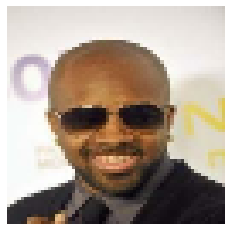

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

# creamos la carpeta donde guardar el dataset
os.makedirs("celeba_gan")

# URL del fichero del dataset en google drive. Lo descargamos con gdown
# Esta operación puede tardar un poco ya que se trata de 1,3GB
url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)
# Descomprimimos el fichero zip descargado
with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

# En esta práctica vamos a trabajar con tamaño de imágenes de 64x64
height = 64
width = 64
channels = 3
batch_size = 32

# Creamos un objeto tf.data.dataset
dataset = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(height, width), batch_size=batch_size
)
dataset = dataset.map(lambda x: x / 255.0) # normalizamos los valores

# Veamos una imagen de muestra
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

## 1. Un boceto de la implementación

Vamos a ver cómo implementar una GAN en su forma más básica. Se han realizado avances significativos que requieren un estudio más profundo de detalles técnicos que quedan fuera de una introducción. Nuestra implementación será una GAN usando una red convolucional conocida como DCGAN (el generador y el discriminador son redes convolucionales). Como en el ejemplo anterior, usaremos la traspuesta de la convolución para pasar de un vector a una imagen en el generador.

Entrenaremos nuestra GAN con imágenes de CelebA. Esta vez tenemos que recorrer las imágenes desde una carpeta. Una forma de hacerlo es con `tf.data.dataset`, el cual nos da la facilidad de recorrer un dataset en batches con un iterador. Tenemos que ampliar el dataset tantas veces como iteraciones querrámos dar.

Esquemáticamente, nuestra GAN hará lo siguiente:

* La red `generadora` mapeará vectores de tamaño  `(latent_dim,)` a imágenes de tamaño `(32, 32, 3)`.
* La red `discriminadora` mapeará imágenes de tamaño (32, 32, 3) a una probabilidad entre 0 y 1.
* Uniremos las dos redes formando una cadena para formar la `gan`: `gan(x) = discriminador(generador(x))`. Esta composición nos dirá como de real es una imagen mapeada desde el espacio latente. 
* Entrenaremos el discriminador usando muestras reales y falsas generadas por el generador. Las muestras reales tendrán asociadas las etiqueta 1 y las generadas por el generador etiqueta 0. 
* Para entrenar el generador usaremos los gradientes usando como función de coste a la red `gan` anterior. Por tanto en cada iteración debemos actualizar los pesos del generador, de forma que hagamos que el discriminador vea las muestras generadas como más reales. 



## 2. Unos trucos para hacer una GAN efectiva

Como hemos mencionado, entrenar una GAN es complicado, por lo que hay una serie de trucos que hay que tener en mente. Como la mayoría de las cosas en Deep Learning, es más alquimia que ciencia. Estos trucos son heurísticos, no existe una teoría que los respalde. Si hay cierta idea intuitiva de por qué funcionan y está comprobado empíricamente, pero no necesariamente tiene que funcionar en todos los contextos.

Veremos algunos de los trucos que usaremos en nuestra implementación pero puedes encontrar más en la literatura:

* Usaremos la activación `tanh` como la última activación del generador en vez de una `sigmoid` (como suele ser usada para modelos similares).
* Muestrearemos puntos del espacio latente usando una *distribución normal* en vez de una distribución uniforme.
* La aleatoriedad nos ayuda a ganar robustez. Evitaremos que el entrenamiento se quede atascado. Introduciremos esta aletoriedad de dos formas:
  1. Usaremos dropout en el discriminador.
  2. Añadiremos ruido a las etiquetas del discriminador.


* Los gradientes dispersos pueden dificultar el entrenamiento. En Deep Learning la dispersión es normalmente deseable, pero no con las GANs. Hay dos elementos que puede producir dispersión:
  1. Las operaciones Max Pooling. Usaremos convoluciones por un paso mayor a 1 para llevar a cabo la reducción de dimensionalidad.
  2. Las activaciones ReLU. Usaremos la activación `LeakyReLU`, muy similar a la ReLU pero reduce la dispersión permitiendo valores negativos de las activaciones.
    
* Las imágenes generadas pueden presentar defectos a modo de píxeles erróneos. Para reducir este efecto usaremos un tamaño de kernel divisible por el paso usado en la convolución.

<img src='https://github.com/miguelamda/DL/blob/master/7.%20Modelos%20Generativos/img/checkboard_effect_caras.png?raw=1' width=60% />

## 3. El generador

Primero, desarrollaremos el modelo del *generador* para convertir un vector en una imagen:

In [3]:
from keras import layers

# Tamaño del espacio latente
latent_dim = 128

# La entrada será del tamaño del espacio latente
generator_input = keras.Input(shape=(latent_dim,))

# Transformamos las entradas a lo que serán 128 mapas 
# de características 8x8:
x = layers.Dense(128 * 8 * 8)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((8, 8, 128))(x)

# Añadimos una capa de convolución:
x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)

# Aplicamos la deconvolución
x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)

# Algunas convoluciones más
x = layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)

# Usamos tanh para la capa de salida con solo 3 mapas = RGB
x = layers.Conv2D(channels, kernel_size=5, padding="same", activation="tanh")(x)

generator = keras.models.Model(generator_input, x, name="generador")
generator.summary()

Model: "generador"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 8192)              1056768   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       52

## 4. El  discriminador


El `discriminador` toma como entrada una imagen y la clasifica como real o no:

In [4]:
# El tamaño de entrada es como el de las imágenes: 64x64
discriminator_input = layers.Input(shape=(height, width, channels))
# Añadimos convoluciones
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(discriminator_input)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Flatten()(x)

# Truco!
x = layers.Dropout(0.2)(x)

# Capa de clasificación
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x, name="discriminador")
discriminator.summary()

# Para estabilizar el entrenamiento usaremos una reducción 
# progresiva del learning rate y recortado de los 
# extremos de los gradientes.
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "discriminador"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)       

## 5. El modelo adversario

Por último definimos la cadena entre el discriminador y el generador. Este es el modelo que hará aprender al generador para mejorar su habilidad de engañar al discriminador. 


In [5]:
# Desactivamos el entrenamiento del discriminador
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

## 6. Entrenamiento de la DCGAN

Ahora empezamos con el entrenamiento. En resumen, el proceso de entrenamiento será el siguiente:

```
Por cada iteración (o época):
    * Muestrear vectores aleatorios del espacios latente (agregando un ruido aleatorio).
    * Generar imágenes con el generador usando estos vectores.
    * Mezclar la imágenes generadas con imágenes reales.
    * Entrenar el `discriminador` usando la mezcla anterior de imágenes con su correspondiente etiqueta.
    * Muestrear nuevos vectores aleatorios del espacio latente.
    * Entrenar la GAN usando esos vectores aleatorios pero con etiquetas diciendo que son reales. Esto hará que  se actualicen los pesos del generador, pero haciendo que las imágenes generadas parezcan más reales al discriminador.
```

Vamos a implementarlo:

In [6]:
from keras.preprocessing import image

# Si no existe la carpeta tmp (solo la primera vez, después descomentar)
save_dir = './tmp'
os.mkdir(save_dir)

# Número de épocas a realizar
epochs = 20000 
# Calculamos el número de iteraciones según el número de épocas y la
# cardinalidad del dataset
iterations = 1+ epochs // dataset.cardinality().numpy()

# Ampliamos el dataset repitiéndolo, hasta que sea igual al número de iteraciones
dataset_iter = dataset.repeat(iterations)

# El bucle principal, sobre cada batch del dataset ampliado
step = 0
for real_images in dataset_iter:
  step += 1

  # Si el batch no está completo, lo saltamos (por ejemplo, hemos dado una
  # vuelta al dataset y por tanto es el último batch, y está incompleto)
  if (len(real_images) < batch_size):
    continue

  # Muestreamos puntos aleatorios del espacio latente
  random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

  # Generamos la imágenes con el generador
  generated_images = generator.predict(random_latent_vectors)

  # Mezclamos con imágenes reales
  combined_images = np.concatenate([generated_images, real_images])

  # Creamos la etiquetas
  labels = np.concatenate([np.ones((batch_size, 1)),
                            np.zeros((batch_size, 1))])
  
  # Añadimos un ruido aleatorio a las etiquetas - Truco!
  labels += 0.05 * np.random.random(labels.shape)

  # Entrenamos el discriminador
  d_loss = discriminator.train_on_batch(combined_images, labels)

  # Muestreamos puntos del espacio latente
  random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

  # Las asociamos con muestras reales (no lo son!)
  misleading_targets = np.zeros((batch_size, 1))

  # Entrenamos el generador usando el modelo gan
  # que tiene los pesos del discriminador congelados
  a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)  

  # Cada paso 100, guardamos unas imágenes
  if step % 100 == 0:
        # Guardamos los pesos del modelo en este paso, de esta forma
        # si la sesión nos caduca, podemos retomarlo por donde lo dejamos
        gan.save_weights('gan.h5')

        # Imprimimos las métricas
        print('Pérdida del discriminador en el paso %s: %s' % (step, d_loss))
        print('Pérdida del adversario en el paso %s: %s' % (step, a_loss))

        # Guardamos una imagen generada
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'cara_generada' + str(step) + '.png'))

        # Guardamos una imagen real para comparar
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'cara_real' + str(step) + '.png'))


Pérdida del discriminador en el paso 100: 0.611767590045929
Pérdida del adversario en el paso 100: 1.0804433822631836
Pérdida del discriminador en el paso 200: 0.7142280340194702
Pérdida del adversario en el paso 200: 1.0270586013793945
Pérdida del discriminador en el paso 300: 0.674440860748291
Pérdida del adversario en el paso 300: 0.7653228044509888
Pérdida del discriminador en el paso 400: 0.6284991502761841
Pérdida del adversario en el paso 400: 1.2320724725723267
Pérdida del discriminador en el paso 500: 0.6265689134597778
Pérdida del adversario en el paso 500: 0.9185292720794678
Pérdida del discriminador en el paso 600: 0.7998969554901123
Pérdida del adversario en el paso 600: 1.560258388519287
Pérdida del discriminador en el paso 700: 0.6580196619033813
Pérdida del adversario en el paso 700: 1.1697654724121094
Pérdida del discriminador en el paso 800: 0.7833218574523926
Pérdida del adversario en el paso 800: 1.3112623691558838
Pérdida del discriminador en el paso 900: 0.6108412

Veamos algunas de las imágenes generadas por nuestra GAN (en realidad, por nuestro generador):

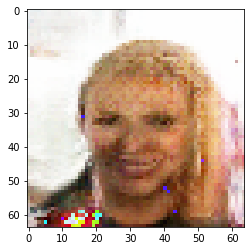

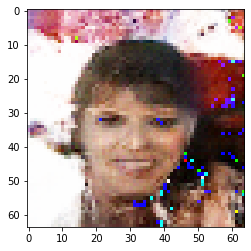

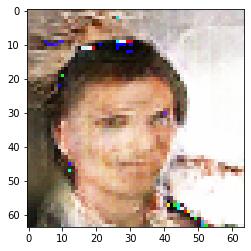

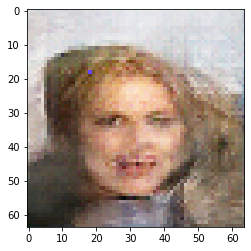

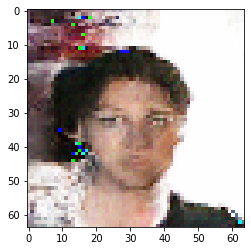

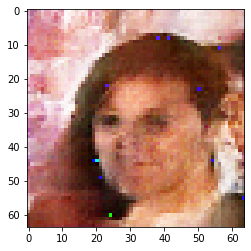

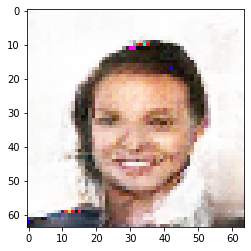

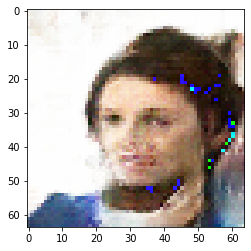

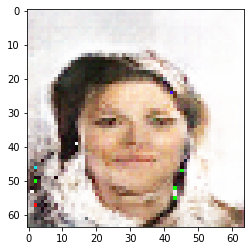

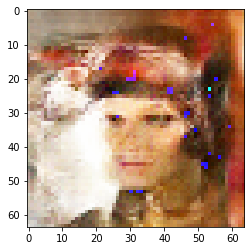

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
# Muestreamos puntos aleatorios en el espacio latente
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Los decodificamos para imágenes falsas
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

Si te interesa profundizar más, puedes encontrar implementaciones de diferentes GANs en el repositorio de github [Keras-GAN
](https://github.com/eriklindernoren/Keras-GAN) y en los ejemplos de la web oficial de [Keras](https://keras.io/examples/generative/).